# Write a Machine Learning Algorithm from Scratch using Python
> Handwritten Digit Recognition with Logistic Regression

- toc:true
- brach: master
- comments: true
- author: Chong-Chong He (che1234@umd.edu)
- image: https://i.imgur.com/SGP0FsX.png
- categories: [machine learning, Python, jupyter]

In this notebook, I demonstrate how to write an image classification algorithm with logistic regression from scratch using Python and achieve high accuracy in the task of Handwritten Digit Recognition.

## Dataset

The data we are going to use to train our model is the MNIST handwritten digit database. First, download the images data files from [the MNIST database](http://yann.lecun.com/exdb/mnist/) and store them under the data/ directory. In this project, we use 8000 images for training and 2000 for testing. The image files are tables of a large set of images, each consisting of 28^2 pixels and each pixel is a 8-bit integer. 

In [1]:
import numpy as np
from scipy import special
import idx2numpy
import matplotlib.pyplot as plt

# reduce num_data to increase the speed of the code
num_data = 3000

image_size = 28
num_test = num_data // 6
x_train = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')[:num_data, :, :].reshape([num_data, image_size * image_size]).T
x_test = idx2numpy.convert_from_file('data/t10k-images-idx3-ubyte')[:num_test, :, :].reshape([num_test, image_size * image_size]).T
y_train = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')[:num_data]
y_test = idx2numpy.convert_from_file('data/t10k-labels-idx1-ubyte')[:num_test]

Let's visualize 10 images that is randomly picked. You will see the images match with the labels.

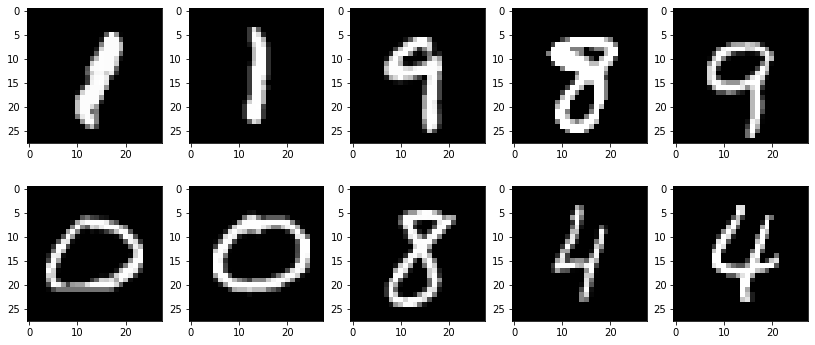

Labels:  [1 1 9 8 9 0 0 8 4 4]


In [2]:
picks = np.random.choice(range(len(y_test)), 10)
f, axs = plt.subplots(2, 5, figsize=[14, 6])
for i, ax in enumerate(axs.flatten()):
    ax.set_aspect('equal', 'box')
    ax.imshow(x_test[:, picks[i]].reshape(image_size, image_size), cmap="gray")
plt.show()
# print("Labels mod: ", y_test[:, picks].T)
print("Labels: ", y_test[picks])

## Training a binary classification model with logistic regression

We begin with a simpler version of the task: binary classification. In a binary classification model, we estimate the probability of some event being true. In this case, we tell if or not an image corresponds to the digit "1". That means, the model will return 1 if the digit is 1 and 0 otherwise. We keep only 1's in the labels and the rest is set to zero. In the next section, we will extend the model to recoganizing all 10 digits. 

We first reset the labels.

In [3]:
y_train_binary = y_train.copy()
y_test_binary = y_test.copy()
y_train_binary[y_train_binary != 1] = 0
y_test_binary[y_test_binary != 1] = 0
y_test_binary[picks]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

The training and test datasets are ready to be used in the model. Let us develop the model.

### Linear regression

The logistic regression uses the basic linear regression formula that we all learned in high school: $y = a x + b$. In logistic regression variables are expressed in vectors:

$$
z = w^T x + b
$$

Here $z$ is the output variable, $x$ is the input variable, $w$ and $b$ are model parameters. Here $b$ is scalar and both $x$ and $w$ are **column vectores**:

$$
{\displaystyle {\boldsymbol {x}}={\begin{bmatrix}x_{1}\\x_{2}\\\vdots \\x_{m}\end{bmatrix}}\,.}
$$

Therefore $w^T x$ means multiply all the elements of $w$ by all the elements of $x$ and add them together. 

### Sigmoid function

This output z is passed through a non-linear function. The commonly used nonlinear function is the sigmoid function that returns a value between 0 and 1.

$$
y_{\rm predict} \equiv a = \frac{1}{1 + e^{-z}}.
$$

In [4]:
def sigmoid(z):
    s = 1/(1 + np.exp(-z))
    return s

### Cost Function

The cost function is a measure of a model that reflects how much the predicted output differs from the original output. The purpose of the training is to reduce the cost function as much as possible. Here is the formula for the cost function of one training example or one row of data:

$$
J(a, y) = - y \log a - (1 - y) \log (1 - a),
$$

and the average cost function for all the rows is

$$
J = \frac{1}{m} \Sigma_{i=1}^{m} J(a, y).
$$

Here $a$ is the sigmoid function from above and $y$ is the label of the training data: 0 or 1. Note how a large $a$ with $y = 1$ or a small $a$ with $y = 0$ reduces $J$. 

A special procedure here is conserved with zero values in the log function. Althrough mathematically $a$ takes values in the range (0, 1), not including 0 or 1, in practice, roundoff error could cause $a = 0$ when $z$ is very small or $a = 1$ when $z$ is large. To avoid `J = NaN` in the program, we wrap the Sigmoid function in the following functions: (see 
The way I solve this problem is to evaluate the log of sigmoid via the special.logsumexp function from scipy: `log(a(z)) = - special.logsumexp([0, -z])`. See [this page](https://fa.bianp.net/blog/2019/evaluate_logistic/) for details.

In [5]:
def logsig_lin(z):
    # log(1 / (1 + np.exp(-z))
    return - special.logsumexp([0, -z])

def log1minussig_lin(z):
    # log(1 - 1 / (1 + np.exp(-z))
    return -z - special.logsumexp([0, -z])

logsig = np.vectorize(logsig_lin)
log1minussig = np.vectorize(log1minussig_lin)

### Gradient descent

The goal of model traning is to update the variables `w` and `b` in order to reduce the cost function. They would be initialized as zeros but need to be updated later with better values. Gradient descent will help with that. Let’s see how.

We have expressed the cost function as a function of `a` and `y`, but it can be expressed as a function of `w` and `b` as well, because `a` is derived from `w` and `b`.

$$
\frac{\partial J(a, y)}{\partial w} = \frac{d J(a, y)}{d a} \frac{da}{dz} \frac{\partial z}{\partial w} = x(a - y)
$$

$$
\frac{\partial J(a, y)}{\partial w} = \frac{d J(a, y)}{d a} \frac{da}{dz} \frac{\partial z}{\partial b} = a - y
$$

Therefore,

$$
\frac{\partial J}{\partial w} = \frac{1}{m} (a - y)^T \cdot {\bf x}
$$
$$
\frac{\partial J}{\partial b} = \frac{1}{m} \Sigma_{i=1}^{m} (a - y)
$$

Now, we can write a function to calculate the derivatives of $J$ given the current parameters, w and 
b, and training dataset, X and Y:

In [6]:
def propagate(w, b, X, Y):
    # the number of training data
    m = X.shape[1]
    # calculate the predicted output
    z = np.dot(w.T, X) + b
    A = sigmoid(z)
    # calculate the cost function
    cost = -1/m * np.sum(Y * logsig(z) + (1 - Y) * log1minussig(z))
    # calculate the gradients
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    return dw, db, cost

### Optimize the parameters to best fit the training data

In [7]:
def optimize(w, b, X, Y, num_ite, rate):
    costs = []
    for i in range(num_ite):
        dw, db, cost = propagate(w, b, X, Y)
        # update w and b y deducting the dw and db times learning rate from the previous values
        w -= rate * dw
        b -= rate * db
        # record the cost function value for each 10 iterations
        if i % 10 == 0:
            costs.append(cost)
            print("Iteration:", i)
    # The final updated parameters and gradients
    params = {'w': w, 'b': b}
    grads = {"dw": dw, "db": db}
    return params, grads, costs

We also need a function to predict the output given the model parameters.

In [8]:
def predict(w, b, X):
    A = sigmoid(np.dot(w.T, X) + b)[0]
    # Iterating through A and predict an 1 if the value of A is greater than 0.5 and a 0 otherwise
    return np.array(A > 0.5, dtype=int)

The final function to do the model and print its accuracy:

In [9]:
dim = x_train.shape[0]
# Initializing the w and b as zeros
w = np.zeros([dim, 1])
b = 0
num_ite = 100
rate = 0.005
# Train the model
params, grads, costs = optimize(w, b, x_train, y_train_binary, num_ite, rate)
# Make predictions based on the trained parameters
prediction_train = predict(params['w'], params['b'], x_train)
prediction_test = predict(params['w'], params['b'], x_test)
# Print out the accuracy
print("train accuracy: {} %".format(100 - np.mean(np.abs(prediction_train - y_train_binary)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(prediction_test - y_test_binary)) * 100))
print("Predictions for the picked images:", prediction_test[picks], ", compared to the labels:", y_test_binary[picks])

Iteration: 0
/tmp/ipykernel_76/2922593723.py:2: RuntimeWarning: overflow encountered in exp
  s = 1/(1 + np.exp(-z))
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
train accuracy: 99.23333333333333 %
test accuracy: 99.0 %
Predictions for the picked images: [1 1 0 0 0 0 0 0 0 0] , compared to the labels: [1 1 0 0 0 0 0 0 0 0]


The model achieves 99% accuracy on this simple binary classification task. 

## Training a multi-class classification model

Now it is time to extend our model capability to do a complete image classification. The idea is to optimize the parameters for each individual catagories, in this case 0, 1, 2, ... 9. In the prediction, we find the catogary with the highest probability (Sigmoid value $a(z)$).

First, rebuild the y data

In [10]:
# build y
N = 10  # number of labels
y_train_sparse = np.zeros([N, len(y_train)])
for i in range(len(y_train)):
    y_train_sparse[int(y_train[i]), i] = 1

and the new optimize and predict function

In [11]:
def propagate_multi(w, b, X, Y):
    """
    Params:
        w: (d by N) d is the number of dimensions (pixels), N is the number of catagories (10)
        b: (N)
        X: (d by m) m is the number of data
        Y: (N by m)
        
    Return:
        dw: (d by N)
        db: (N)
        cost: (float)
    """
    # the number of training data
    m = X.shape[1]
    # calculate the predicted output
    z = (np.dot(w.T, X).T + b).T # (N by m)
    A = sigmoid(z)
    cost = -1 / (N * m) * np.sum(Y * logsig(z) + (1 - Y) * log1minussig(z))
    # calculate the gradients
    dw = 1/m * np.dot(X, (A - Y).T) # (d by N)
    db = 1/m * np.sum(A - Y, axis=1) # (N)
    return dw, db, cost

def optimize(w, b, X, Y, num_ite, rate, cost_skip=10):
    # costs = []
    for i in range(num_ite):
        dw, db, cost = propagate_multi(w, b, X, Y)
        # update w and b y deducting the dw and db times learning rate from the previous values
        w -= rate * dw
        b -= rate * db
        # record the cost function value for each 100 iterations
        # if i % 5 == 0:
        #     costs.append(cost)
        #     print(f"Iteration: {i}, cost = {cost}")
    # The final updated parameters and gradients
    params = {'w': w, 'b': b}
    grads = {"dw": dw, "db": db}
    return params, grads, cost

def predict(w, b, X):
    A = sigmoid(np.dot(w.T, X).T + b).T # (N by m)
    return  np.argmax(A, axis=0) # (m)

Now, train the model

In [22]:
# test: find the best num_ite
    
N = 10
# Initializing the w and b as zeros
dim = x_train.shape[0]
w = np.zeros([dim, N])
b = np.zeros(N)
rate = 0.002
params = {'w': w, 'b': b}
ite_per_cycle = 10
for cycle in range(11):
    params, grads, costs = optimize(params['w'], params['b'], x_train, y_train_sparse, ite_per_cycle, rate)
    prediction_train = predict(params['w'], params['b'], x_train)
    print("total number of ite = {}, cost = {}, train accuracy = {} %".format(
        (cycle + 1) * ite_per_cycle,
        costs,
        np.sum(prediction_train == np.array(y_train, dtype=int)) / len(y_train) * 100))
prediction_test = predict(params['w'], params['b'], x_test)
print("test accuracy: {} %".format(np.sum(prediction_test == np.array(y_test, dtype=int)) / len(y_test) * 100))
print("Predictions for the picked images:", prediction_test[picks], ", compared to the labels:", y_test[picks])
# plt.scatter(cost_skip * np.arange(len(costs)), costs)
# plt.gca().set(yscale='log')
# plt.savefig("f2.png", dpi=300)
# print("f2.png: evolution of the costs.")

/tmp/ipykernel_76/2922593723.py:2: RuntimeWarning: overflow encountered in exp
  s = 1/(1 + np.exp(-z))
total number of ite = 10, cost = 15.642082022209852, train accuracy = 78.4 %
total number of ite = 20, cost = 10.13579121822049, train accuracy = 70.1 %
total number of ite = 30, cost = 6.239039228320853, train accuracy = 85.36666666666667 %
total number of ite = 40, cost = 3.974493901128094, train accuracy = 87.66666666666667 %
total number of ite = 50, cost = 8.038727466800148, train accuracy = 78.56666666666666 %
total number of ite = 60, cost = 3.6077143613125293, train accuracy = 82.23333333333333 %
total number of ite = 70, cost = 8.519842639119675, train accuracy = 70.16666666666667 %
total number of ite = 80, cost = 3.059499345101131, train accuracy = 84.89999999999999 %
total number of ite = 90, cost = 3.734900624342142, train accuracy = 87.23333333333333 %
total number of ite = 100, cost = 2.4217790069496483, train accuracy = 84.23333333333333 %
total number of ite = 110, c

The model achieves 91% accuracy on the training dataset and 84% accuracy on the test sample.

## Why does it work?

How could such a simple model achieve such high accuracy in classifying handwritten digits, given the high complexity and variation in the handwritten digits? We can have an appreciation of how it works by taking a visualization of the weight. Recall the each weight correponds to how much each of the input pixels are taken into account. By reshaping the wegiths into a 28 by 28 image, we can tell what pixels are most important and least important:

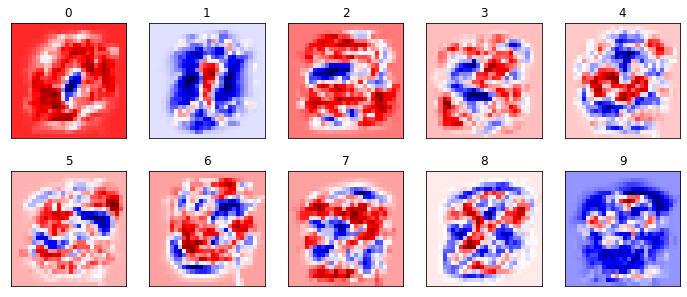

In [23]:
plt.figure(figsize=[12, 5])
for i in range(N):
    plt.subplot(2, 5, i+1)
    weight = params['w'][:, i].reshape([image_size, image_size])
    plt.title(i)
    plt.imshow(weight, cmap="seismic")
    ax = plt.gca().axes
    ax.get_xaxis().set_visible(0)
    ax.get_yaxis().set_visible(0)

Here the colors are weights with red meaning positive and blue meaning negative values. Note how the weights of some of the digits (0, 1, 3, 5, 7, 8) are interpretable. Other digits are more complicated, which might be the reason why the algorithm could not reach very high accuracy. 